<a href="https://colab.research.google.com/github/NID123-CH/LLM-Codes/blob/main/Copy_of_02_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantization Basics

First, let's create a Linear layer with 100 parameters.

In [1]:
import torch
import torch.nn as nn

torch.manual_seed(42)
linear = nn.Linear(10, 10)
weights = linear.weight.flatten()
weights

tensor([ 0.2418,  0.2625, -0.0741,  0.2905, -0.0693,  0.0638, -0.1540,  0.1857,
         0.2788, -0.2320,  0.2749,  0.0592,  0.2336,  0.0428,  0.1525, -0.0446,
         0.2438,  0.0467, -0.1476,  0.0806, -0.1457, -0.0371, -0.1284,  0.2098,
        -0.2496, -0.1458, -0.0893, -0.1901,  0.0298, -0.3123,  0.2856, -0.2686,
         0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,  0.0346, -0.0997,
         0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
         0.1606, -0.1927, -0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,
         0.1000, -0.0055,  0.2475, -0.2247,  0.0199, -0.2158,  0.0975, -0.1089,
         0.0969, -0.0659,  0.2623, -0.1874, -0.1886, -0.1886,  0.2844,  0.1054,
         0.3043, -0.2610, -0.3137, -0.2474, -0.2127,  0.1281,  0.1132,  0.2628,
        -0.1633, -0.2156,  0.1678, -0.1278,  0.1919, -0.0750,  0.1809, -0.2457,
        -0.1596,  0.0964,  0.0669, -0.0806,  0.1885,  0.2150, -0.2293, -0.1688,
         0.2896, -0.1067, -0.1121, -0.30

(array([ 0.,  4., 12., 20., 11., 17., 16., 19.,  1.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

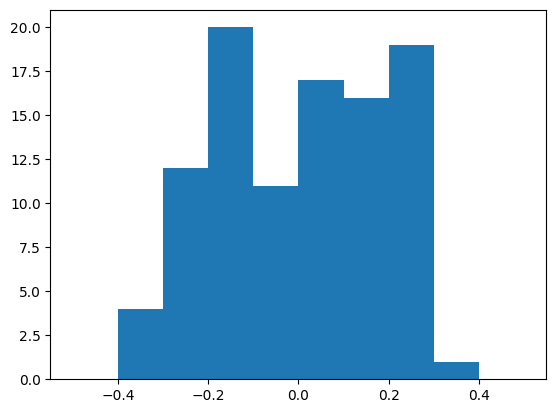

In [2]:
import numpy as np
from matplotlib import pyplot as plt

plt.hist(weights.tolist(), bins=np.linspace(-.5, .5, 11))

## Symmetrical

The highest (absolute) value is around 0.31. We'll use this value to create a symmetrical range and split it into bins:

In [3]:
alpha = weights.abs().max().item()
alpha

0.31365877389907837

How many bins? It depends on how many bits we want to use for quantization:

In [4]:
bits = 8
n_bins = 2**bits
n_bins

256

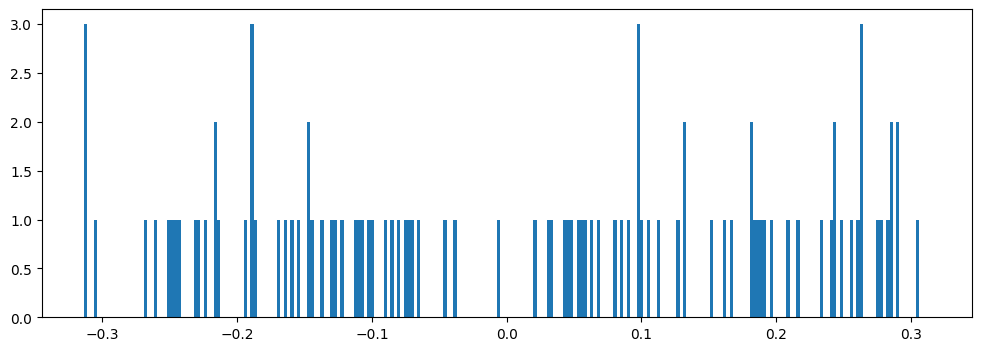

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
counts, bins, _ = ax.hist(weights.tolist(), bins=np.linspace(-alpha, alpha, n_bins-1))

<BarContainer object of 254 artists>

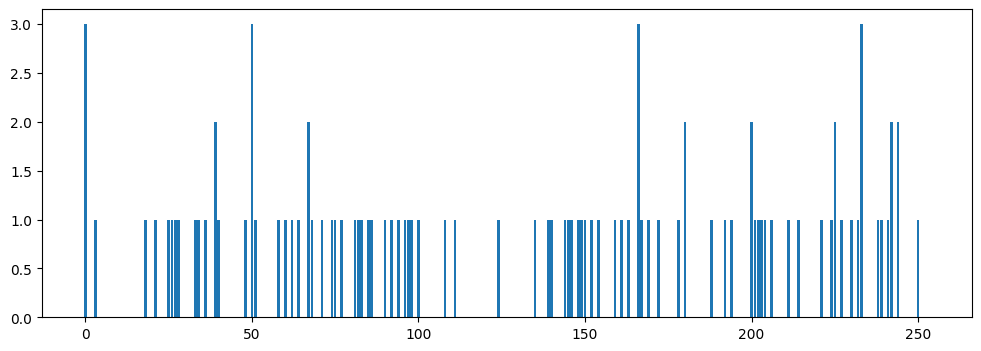

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(np.arange(n_bins-2), counts)

What's the width of each bin? The range is symmetrical, so we divide `alpha` by half the number of bins to get the width:

In [7]:
scale = alpha / (n_bins/2 - 1)
scale
# lower_bound = -int(n_bins/2)
# upper_bound = int(n_bins/2-1)

0.0024697541251895933

Each bin gets its own sequential number, from 0 to `(n_bins-1)`, and each weight is replaced by the bin number where its originl value fell into:

In [8]:
quantized = ((weights + alpha) / scale).round().to(torch.uint8).clamp(0, n_bins-1)
quantized

tensor([225, 233,  97, 245,  99, 153,  65, 202, 240,  33, 238, 151, 222, 144,
        189, 109, 226, 146,  67, 160,  68, 112,  75, 212,  26,  68,  91,  50,
        139,   1, 243,  18, 226, 148,  85, 206, 147, 230, 141,  87, 161,  92,
        181, 241, 201,  71, 201, 150, 192,  49,   0,  78,  29, 232, 164, 180,
        167, 125, 227,  36, 135,  40, 166,  83, 166, 100, 233,  51,  51,  51,
        242, 170, 250,  21,   0,  27,  41, 179, 173, 233,  61,  40, 195,  75,
        205,  97, 200,  28,  62, 166, 154,  94, 203, 214,  34,  59, 244,  84,
         82,   3], dtype=torch.uint8)

Is it good? We can reconstruct the values and compare to the original ones, and the compute RMSE:

In [9]:
dequantized = quantized*scale-alpha
dequantized

tensor([ 0.2420,  0.2618, -0.0741,  0.2914, -0.0692,  0.0642, -0.1531,  0.1852,
         0.2791, -0.2322,  0.2741,  0.0593,  0.2346,  0.0420,  0.1531, -0.0445,
         0.2445,  0.0469, -0.1482,  0.0815, -0.1457, -0.0370, -0.1284,  0.2099,
        -0.2494, -0.1457, -0.0889, -0.1902,  0.0296, -0.3112,  0.2865, -0.2692,
         0.2445,  0.0519, -0.1037,  0.1951,  0.0494,  0.2544,  0.0346, -0.0988,
         0.0840, -0.0864,  0.1334,  0.2816,  0.1828, -0.1383,  0.1828,  0.0568,
         0.1605, -0.1926, -0.3137, -0.1210, -0.2420,  0.2593,  0.0914,  0.1309,
         0.0988, -0.0049,  0.2470, -0.2247,  0.0198, -0.2149,  0.0963, -0.1087,
         0.0963, -0.0667,  0.2618, -0.1877, -0.1877, -0.1877,  0.2840,  0.1062,
         0.3038, -0.2618, -0.3137, -0.2470, -0.2124,  0.1284,  0.1136,  0.2618,
        -0.1630, -0.2149,  0.1679, -0.1284,  0.1926, -0.0741,  0.1803, -0.2445,
        -0.1605,  0.0963,  0.0667, -0.0815,  0.1877,  0.2149, -0.2297, -0.1679,
         0.2890, -0.1062, -0.1111, -0.30

In [10]:
weights

tensor([ 0.2418,  0.2625, -0.0741,  0.2905, -0.0693,  0.0638, -0.1540,  0.1857,
         0.2788, -0.2320,  0.2749,  0.0592,  0.2336,  0.0428,  0.1525, -0.0446,
         0.2438,  0.0467, -0.1476,  0.0806, -0.1457, -0.0371, -0.1284,  0.2098,
        -0.2496, -0.1458, -0.0893, -0.1901,  0.0298, -0.3123,  0.2856, -0.2686,
         0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,  0.0346, -0.0997,
         0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
         0.1606, -0.1927, -0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,
         0.1000, -0.0055,  0.2475, -0.2247,  0.0199, -0.2158,  0.0975, -0.1089,
         0.0969, -0.0659,  0.2623, -0.1874, -0.1886, -0.1886,  0.2844,  0.1054,
         0.3043, -0.2610, -0.3137, -0.2474, -0.2127,  0.1281,  0.1132,  0.2628,
        -0.1633, -0.2156,  0.1678, -0.1278,  0.1919, -0.0750,  0.1809, -0.2457,
        -0.1596,  0.0964,  0.0669, -0.0806,  0.1885,  0.2150, -0.2293, -0.1688,
         0.2896, -0.1067, -0.1121, -0.30

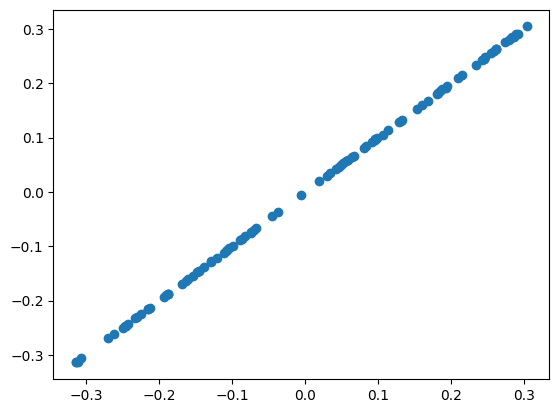

In [11]:
plt.scatter(dequantized.tolist(), weights.tolist())

In [12]:
loss_fn = nn.MSELoss()
torch.sqrt(loss_fn(quantized*scale-alpha, weights))

tensor(0.0006, grad_fn=<SqrtBackward0>)

## Asymmetrical

Instead of using a perfectly symmetrical range, we can use actual minimum and maximum values instead:

In [13]:
alpha = weights.max().item()
beta = weights.min().item()
scale = (alpha-beta) / (n_bins-1)

beta, alpha, scale

(-0.31365877389907837, 0.30429038405418396, 0.002423330031189264)

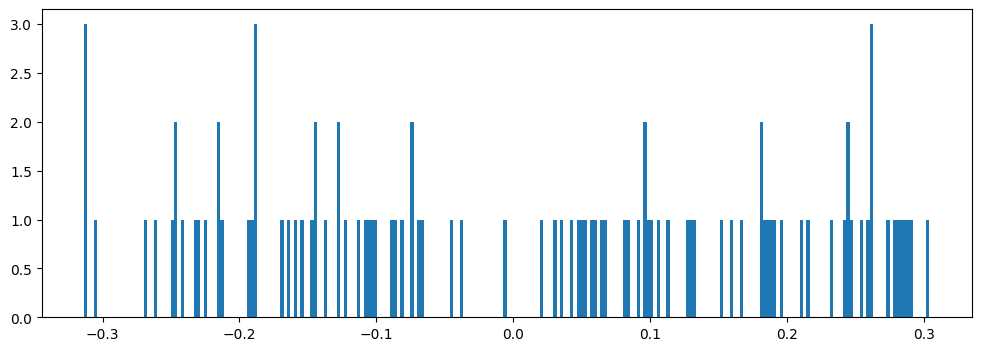

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
counts, bins, _ = ax.hist(weights.tolist(), bins=np.linspace(beta, alpha, n_bins-1))

Since the range is asymmetrical, we need to figure out its center (`zero`).

In [15]:
zero = -round(beta / scale)
zero

129

Now, let's quantize the weights once again:

In [16]:
lower_bound = 0
upper_bound = n_bins - 1
# quantized = ((weights + beta) / scale).round().to(torch.uint8).clamp(lower_bound, upper_bound)
# it is equivalent to
quantized = (weights / scale + zero).round().to(torch.uint8).clamp(lower_bound, upper_bound)
quantized

tensor([229, 237,  98, 249, 100, 155,  65, 206, 244,  33, 242, 153, 225, 147,
        192, 111, 230, 148,  68, 162,  69, 114,  76, 216,  26,  69,  92,  51,
        141,   0, 247,  18, 230, 151,  87, 210, 149, 234, 143,  88, 164,  94,
        184, 246, 204,  72, 204, 152, 195,  49,   0,  79,  29, 236, 167, 183,
        170, 127, 231,  36, 137,  40, 169,  84, 169, 102, 237,  52,  51,  51,
        246, 172, 255,  21,   0,  27,  41, 182, 176, 237,  62,  40, 198,  76,
        208,  98, 204,  28,  63, 169, 157,  96, 207, 218,  34,  59, 248,  85,
         83,   3], dtype=torch.uint8)

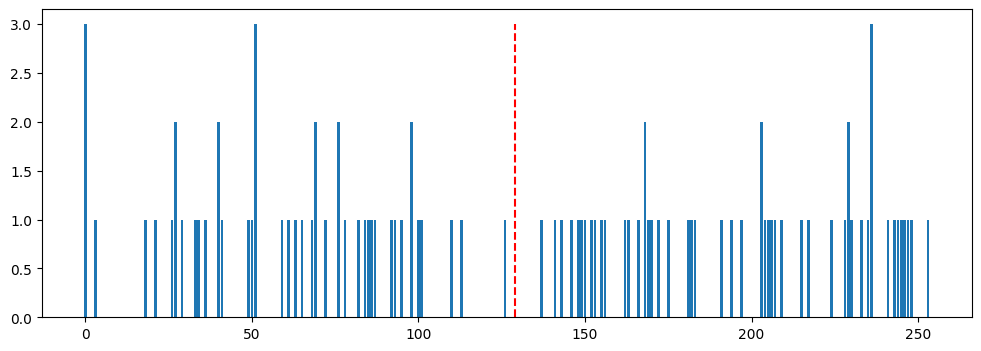

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.bar(np.arange(n_bins-2), counts)
ax.plot([zero, zero], [0, 3], c='r', linestyle='--')

Is it any good? Let's dequantize and compare:

In [18]:
quantized, zero, quantized - zero

(tensor([229, 237,  98, 249, 100, 155,  65, 206, 244,  33, 242, 153, 225, 147,
         192, 111, 230, 148,  68, 162,  69, 114,  76, 216,  26,  69,  92,  51,
         141,   0, 247,  18, 230, 151,  87, 210, 149, 234, 143,  88, 164,  94,
         184, 246, 204,  72, 204, 152, 195,  49,   0,  79,  29, 236, 167, 183,
         170, 127, 231,  36, 137,  40, 169,  84, 169, 102, 237,  52,  51,  51,
         246, 172, 255,  21,   0,  27,  41, 182, 176, 237,  62,  40, 198,  76,
         208,  98, 204,  28,  63, 169, 157,  96, 207, 218,  34,  59, 248,  85,
          83,   3], dtype=torch.uint8),
 129,
 tensor([100, 108, 225, 120, 227,  26, 192,  77, 115, 160, 113,  24,  96,  18,
          63, 238, 101,  19, 195,  33, 196, 241, 203,  87, 153, 196, 219, 178,
          12, 127, 118, 145, 101,  22, 214,  81,  20, 105,  14, 215,  35, 221,
          55, 117,  75, 199,  75,  23,  66, 176, 127, 206, 156, 107,  38,  54,
          41, 254, 102, 163,   8, 167,  40, 211,  40, 229, 108, 179, 178, 178,
      

In [19]:
dequantized = (quantized - zero)*scale
dequantized

tensor([0.2423, 0.2617, 0.5452, 0.2908, 0.5501, 0.0630, 0.4653, 0.1866, 0.2787,
        0.3877, 0.2738, 0.0582, 0.2326, 0.0436, 0.1527, 0.5768, 0.2448, 0.0460,
        0.4725, 0.0800, 0.4750, 0.5840, 0.4919, 0.2108, 0.3708, 0.4750, 0.5307,
        0.4314, 0.0291, 0.3078, 0.2860, 0.3514, 0.2448, 0.0533, 0.5186, 0.1963,
        0.0485, 0.2544, 0.0339, 0.5210, 0.0848, 0.5356, 0.1333, 0.2835, 0.1817,
        0.4822, 0.1817, 0.0557, 0.1599, 0.4265, 0.3078, 0.4992, 0.3780, 0.2593,
        0.0921, 0.1309, 0.0994, 0.6155, 0.2472, 0.3950, 0.0194, 0.4047, 0.0969,
        0.5113, 0.0969, 0.5549, 0.2617, 0.4338, 0.4314, 0.4314, 0.2835, 0.1042,
        0.3053, 0.3587, 0.3078, 0.3732, 0.4071, 0.1284, 0.1139, 0.2617, 0.4580,
        0.4047, 0.1672, 0.4919, 0.1914, 0.5452, 0.1817, 0.3756, 0.4604, 0.0969,
        0.0679, 0.5404, 0.1890, 0.2157, 0.3902, 0.4507, 0.2884, 0.5137, 0.5089,
        0.3150])

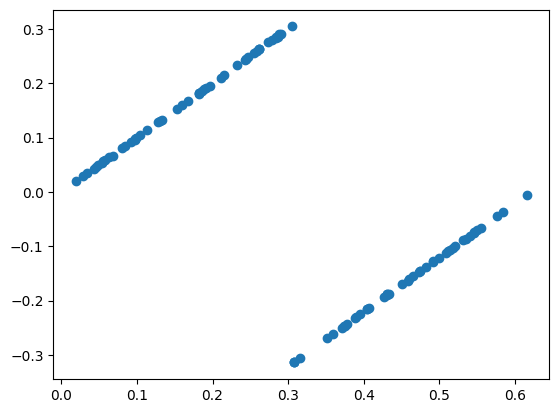

In [20]:
plt.scatter(dequantized.tolist(), weights.tolist())

Clearly, something is terribly wrong! Can you guess what happened?

Let's try it once again:

In [21]:
dequantized = quantized*scale-zero*scale
dequantized

tensor([ 0.2423,  0.2617, -0.0751,  0.2908, -0.0703,  0.0630, -0.1551,  0.1866,
         0.2787, -0.2326,  0.2738,  0.0582,  0.2326,  0.0436,  0.1527, -0.0436,
         0.2448,  0.0460, -0.1478,  0.0800, -0.1454, -0.0363, -0.1284,  0.2108,
        -0.2496, -0.1454, -0.0897, -0.1890,  0.0291, -0.3126,  0.2860, -0.2690,
         0.2448,  0.0533, -0.1018,  0.1963,  0.0485,  0.2544,  0.0339, -0.0994,
         0.0848, -0.0848,  0.1333,  0.2835,  0.1817, -0.1381,  0.1817,  0.0557,
         0.1599, -0.1939, -0.3126, -0.1212, -0.2423,  0.2593,  0.0921,  0.1309,
         0.0994, -0.0048,  0.2472, -0.2254,  0.0194, -0.2157,  0.0969, -0.1090,
         0.0969, -0.0654,  0.2617, -0.1866, -0.1890, -0.1890,  0.2835,  0.1042,
         0.3053, -0.2617, -0.3126, -0.2472, -0.2133,  0.1284,  0.1139,  0.2617,
        -0.1624, -0.2157,  0.1672, -0.1284,  0.1914, -0.0751,  0.1817, -0.2448,
        -0.1599,  0.0969,  0.0679, -0.0800,  0.1890,  0.2157, -0.2302, -0.1696,
         0.2884, -0.1066, -0.1115, -0.30

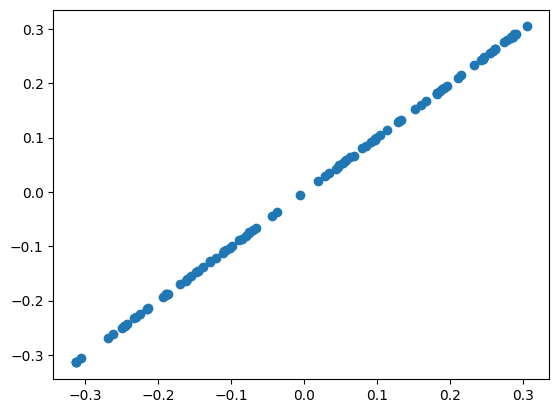

In [22]:
plt.scatter(dequantized.tolist(), weights.tolist())

In [23]:
torch.sqrt(loss_fn(quantized*scale-zero*scale, weights))

tensor(0.0007, grad_fn=<SqrtBackward0>)

# Define the quantization methods and quantize

In [24]:
def clamp(params_q: np.array, lower_bound: int, upper_bound: int) -> np.array:
    params_q[params_q < lower_bound] = lower_bound
    params_q[params_q > upper_bound] = upper_bound
    return params_q

def asymmetric_quantization(params: np.array, bits: int) -> tuple[np.array, float, int]:
    # Calculate the scale and zero point
    alpha = np.max(params)
    beta = np.min(params)
    scale = (alpha - beta) / (2**bits-1)
    zero = -np.round(beta / scale)
    lower_bound, upper_bound = 0, 2**bits-1
    # Quantize the parameters
    quantized = clamp(np.round(params / scale + zero), lower_bound, upper_bound).astype(np.int32)
    return quantized, scale, zero

def asymmetric_dequantize(params_q: np.array, scale: float, zero: int) -> np.array:
    return (params_q - zero) * scale

def symmetric_dequantize(params_q: np.array, scale: float) -> np.array:
    return params_q * scale

def symmetric_quantization(params: np.array, bits: int) -> tuple[np.array, float]:
    # Calculate the scale
    alpha = np.max(np.abs(params))
    scale = alpha / (2**(bits-1)-1)
    lower_bound = -2**(bits-1)
    upper_bound = 2**(bits-1)-1
    # Quantize the parameters
    quantized = clamp(np.round(params / scale), lower_bound, upper_bound).astype(np.int32)
    return quantized, scale

def quantization_error(params: np.array, params_q: np.array):
    # calculate the MSE
    return np.sqrt(np.mean((params - params_q)**2))

In [25]:
params = weights.detach().numpy()

(asymmetric_q, asymmetric_scale, asymmetric_zero) = asymmetric_quantization(params, bits)
(symmetric_q, symmetric_scale) = symmetric_quantization(params, bits)

print(f'Original:')
print(np.round(params, 2))
print('')
print(f'Asymmetric scale: {asymmetric_scale}, zero: {asymmetric_zero}')
print(asymmetric_q)
print('')
print(f'Symmetric scale: {symmetric_scale}')
print(symmetric_q)

Original:
[ 0.24  0.26 -0.07  0.29 -0.07  0.06 -0.15  0.19  0.28 -0.23  0.27  0.06
  0.23  0.04  0.15 -0.04  0.24  0.05 -0.15  0.08 -0.15 -0.04 -0.13  0.21
 -0.25 -0.15 -0.09 -0.19  0.03 -0.31  0.29 -0.27  0.24  0.05 -0.1   0.2
  0.05  0.26  0.03 -0.1   0.08 -0.09  0.13  0.28  0.18 -0.14  0.18  0.06
  0.16 -0.19 -0.31 -0.12 -0.24  0.26  0.09  0.13  0.1  -0.01  0.25 -0.22
  0.02 -0.22  0.1  -0.11  0.1  -0.07  0.26 -0.19 -0.19 -0.19  0.28  0.11
  0.3  -0.26 -0.31 -0.25 -0.21  0.13  0.11  0.26 -0.16 -0.22  0.17 -0.13
  0.19 -0.08  0.18 -0.25 -0.16  0.1   0.07 -0.08  0.19  0.21 -0.23 -0.17
  0.29 -0.11 -0.11 -0.31]

Asymmetric scale: 0.0024233299143174114, zero: 129.0
[229 237  98 249 100 155  65 206 244  33 242 153 225 147 192 111 230 148
  68 162  69 114  76 216  26  69  92  51 141   0 247  18 230 151  87 210
 149 234 143  88 164  94 184 246 204  72 204 152 195  49   0  79  29 236
 167 183 170 127 231  36 137  40 169  84 169 102 237  52  51  51 246 172
 255  21   0  27  41 182 176 237  6

In [26]:
# Dequantize the parameters back to 32 bits
params_deq_asymmetric = asymmetric_dequantize(asymmetric_q, asymmetric_scale, asymmetric_zero)
params_deq_symmetric = symmetric_dequantize(symmetric_q, symmetric_scale)

print(f'Original:')
print(np.round(params, 2))
print('')
print(f'Dequantize Asymmetric:')
print(np.round(params_deq_asymmetric,2))
print('')
print(f'Dequantize Symmetric:')
print(np.round(params_deq_symmetric, 2))

Original:
[ 0.24  0.26 -0.07  0.29 -0.07  0.06 -0.15  0.19  0.28 -0.23  0.27  0.06
  0.23  0.04  0.15 -0.04  0.24  0.05 -0.15  0.08 -0.15 -0.04 -0.13  0.21
 -0.25 -0.15 -0.09 -0.19  0.03 -0.31  0.29 -0.27  0.24  0.05 -0.1   0.2
  0.05  0.26  0.03 -0.1   0.08 -0.09  0.13  0.28  0.18 -0.14  0.18  0.06
  0.16 -0.19 -0.31 -0.12 -0.24  0.26  0.09  0.13  0.1  -0.01  0.25 -0.22
  0.02 -0.22  0.1  -0.11  0.1  -0.07  0.26 -0.19 -0.19 -0.19  0.28  0.11
  0.3  -0.26 -0.31 -0.25 -0.21  0.13  0.11  0.26 -0.16 -0.22  0.17 -0.13
  0.19 -0.08  0.18 -0.25 -0.16  0.1   0.07 -0.08  0.19  0.21 -0.23 -0.17
  0.29 -0.11 -0.11 -0.31]

Dequantize Asymmetric:
[ 0.24  0.26 -0.08  0.29 -0.07  0.06 -0.16  0.19  0.28 -0.23  0.27  0.06
  0.23  0.04  0.15 -0.04  0.24  0.05 -0.15  0.08 -0.15 -0.04 -0.13  0.21
 -0.25 -0.15 -0.09 -0.19  0.03 -0.31  0.29 -0.27  0.24  0.05 -0.1   0.2
  0.05  0.25  0.03 -0.1   0.08 -0.08  0.13  0.28  0.18 -0.14  0.18  0.06
  0.16 -0.19 -0.31 -0.12 -0.24  0.26  0.09  0.13  0.1  -0.    0.25

In [27]:
# Calculate the quantization error
print(f'{"Asymmetric RMSE: ":>20}{np.round(quantization_error(params, params_deq_asymmetric), 4)}')
print(f'{"Symmetric RMSE: ":>20}{np.round(quantization_error(params, params_deq_symmetric), 4)}')

   Asymmetric RMSE: 0.0007
    Symmetric RMSE: 0.0006
